In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import os
import category_encoders as ce
# Scikit-learn models.
from utils import performance as pe
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

### 1. Import Dataset

The dataset for this tutorial was created by J. A. Blackard in 1998, and it comprises over half a million observations with 54 features. Each observation represents a 30-by-30-meter tract of land in wilderness areas in Colorado. The features record cartographic data about each tract: elevation, aspect, distance to water/roads/past wildfire ignition points, amount of shade at various times of day, and which of 40 soil types it contains.

In [2]:
df = pd.read_table("./data/covtype.data", sep=",", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
df.shape

(581012, 55)

In [4]:
df.dtypes.value_counts()

int64    55
dtype: int64

#### Labelling columns:

In [5]:
df.columns = df.columns.astype(str)

In [6]:
columns_quantitative = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]
wilderness_qualitative = ["Wilderness_Area_"+str(x) for x in range(0, 4)]
soil_qualitative = ["Soil_Type_"+str(x) for x in range(0, 40)]
columns = columns_quantitative + wilderness_qualitative + soil_qualitative + ["Cover_Type"]

In [7]:
df.columns = columns

In [8]:
df.tail()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3
581011,2383,165,13,60,4,67,231,244,141,875,...,0,0,0,0,0,0,0,0,0,3


### 2. Exploration data analysis.

In [9]:
df.iloc[:, :10].columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')

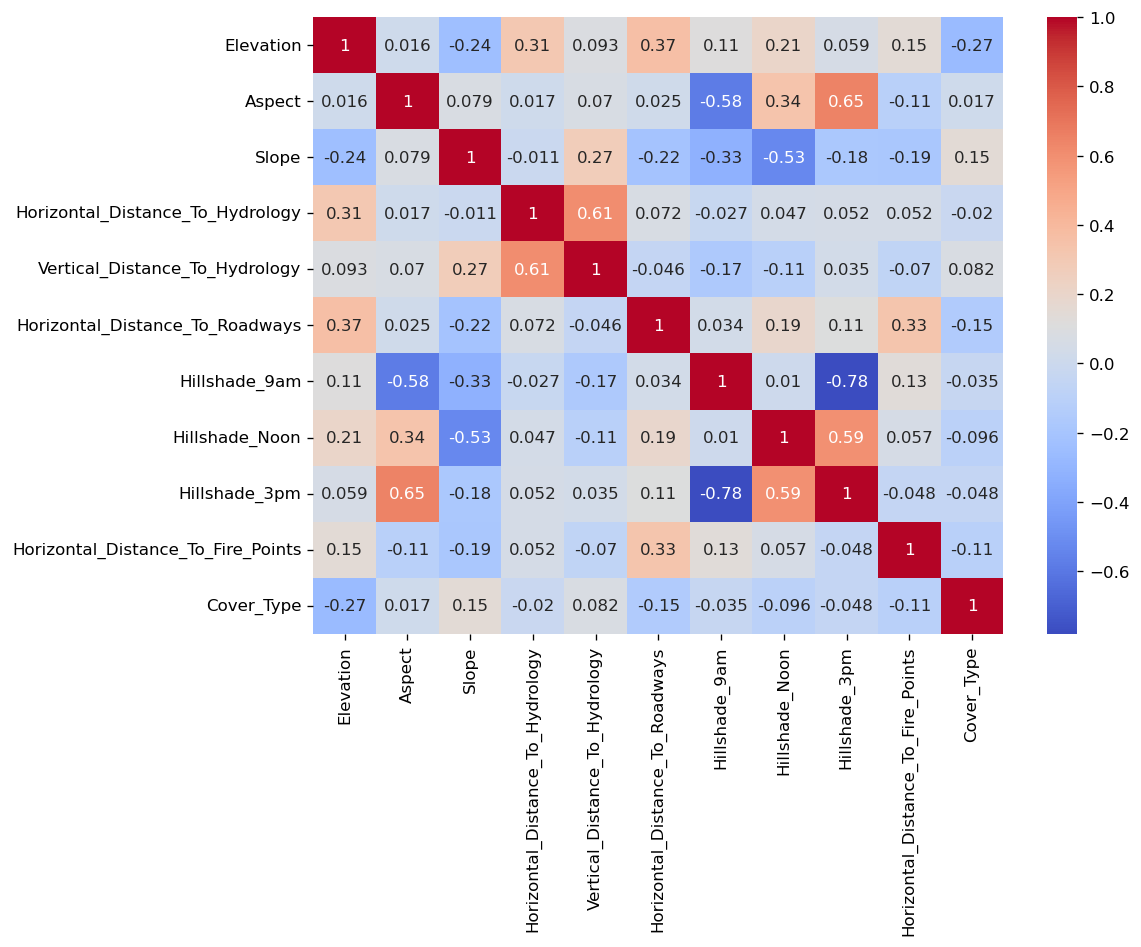

In [10]:
corr_quantitative = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Cover_Type']].corr()
plt.figure(figsize=(10, 8), dpi=120)
sns.heatmap(data=corr_quantitative, cmap="coolwarm", cbar=True, annot=True)
plt.tight_layout()
plt.show()

In [11]:
df.iloc[:, :10].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [12]:
column_names = dict(enumerate(df.iloc[:, :9].columns.tolist()))
custom_palette = dict(
    enumerate(
        [
            "#FF5733",  # Vivid Red
            "#33FF57",  # Vivid Green
            "#3357FF",  # Vivid Blue
            "#FF33A6",  # Vivid Pink
            "#FF8C33",  # Vivid Orange
            "#8C33FF",  # Vivid Purple
            "#33FFF6",  # Vivid Cyan
            "#F6FF33",  # Vivid Yellow
            "#33FF8C"   # Vivid Mint
        ]
    )
)

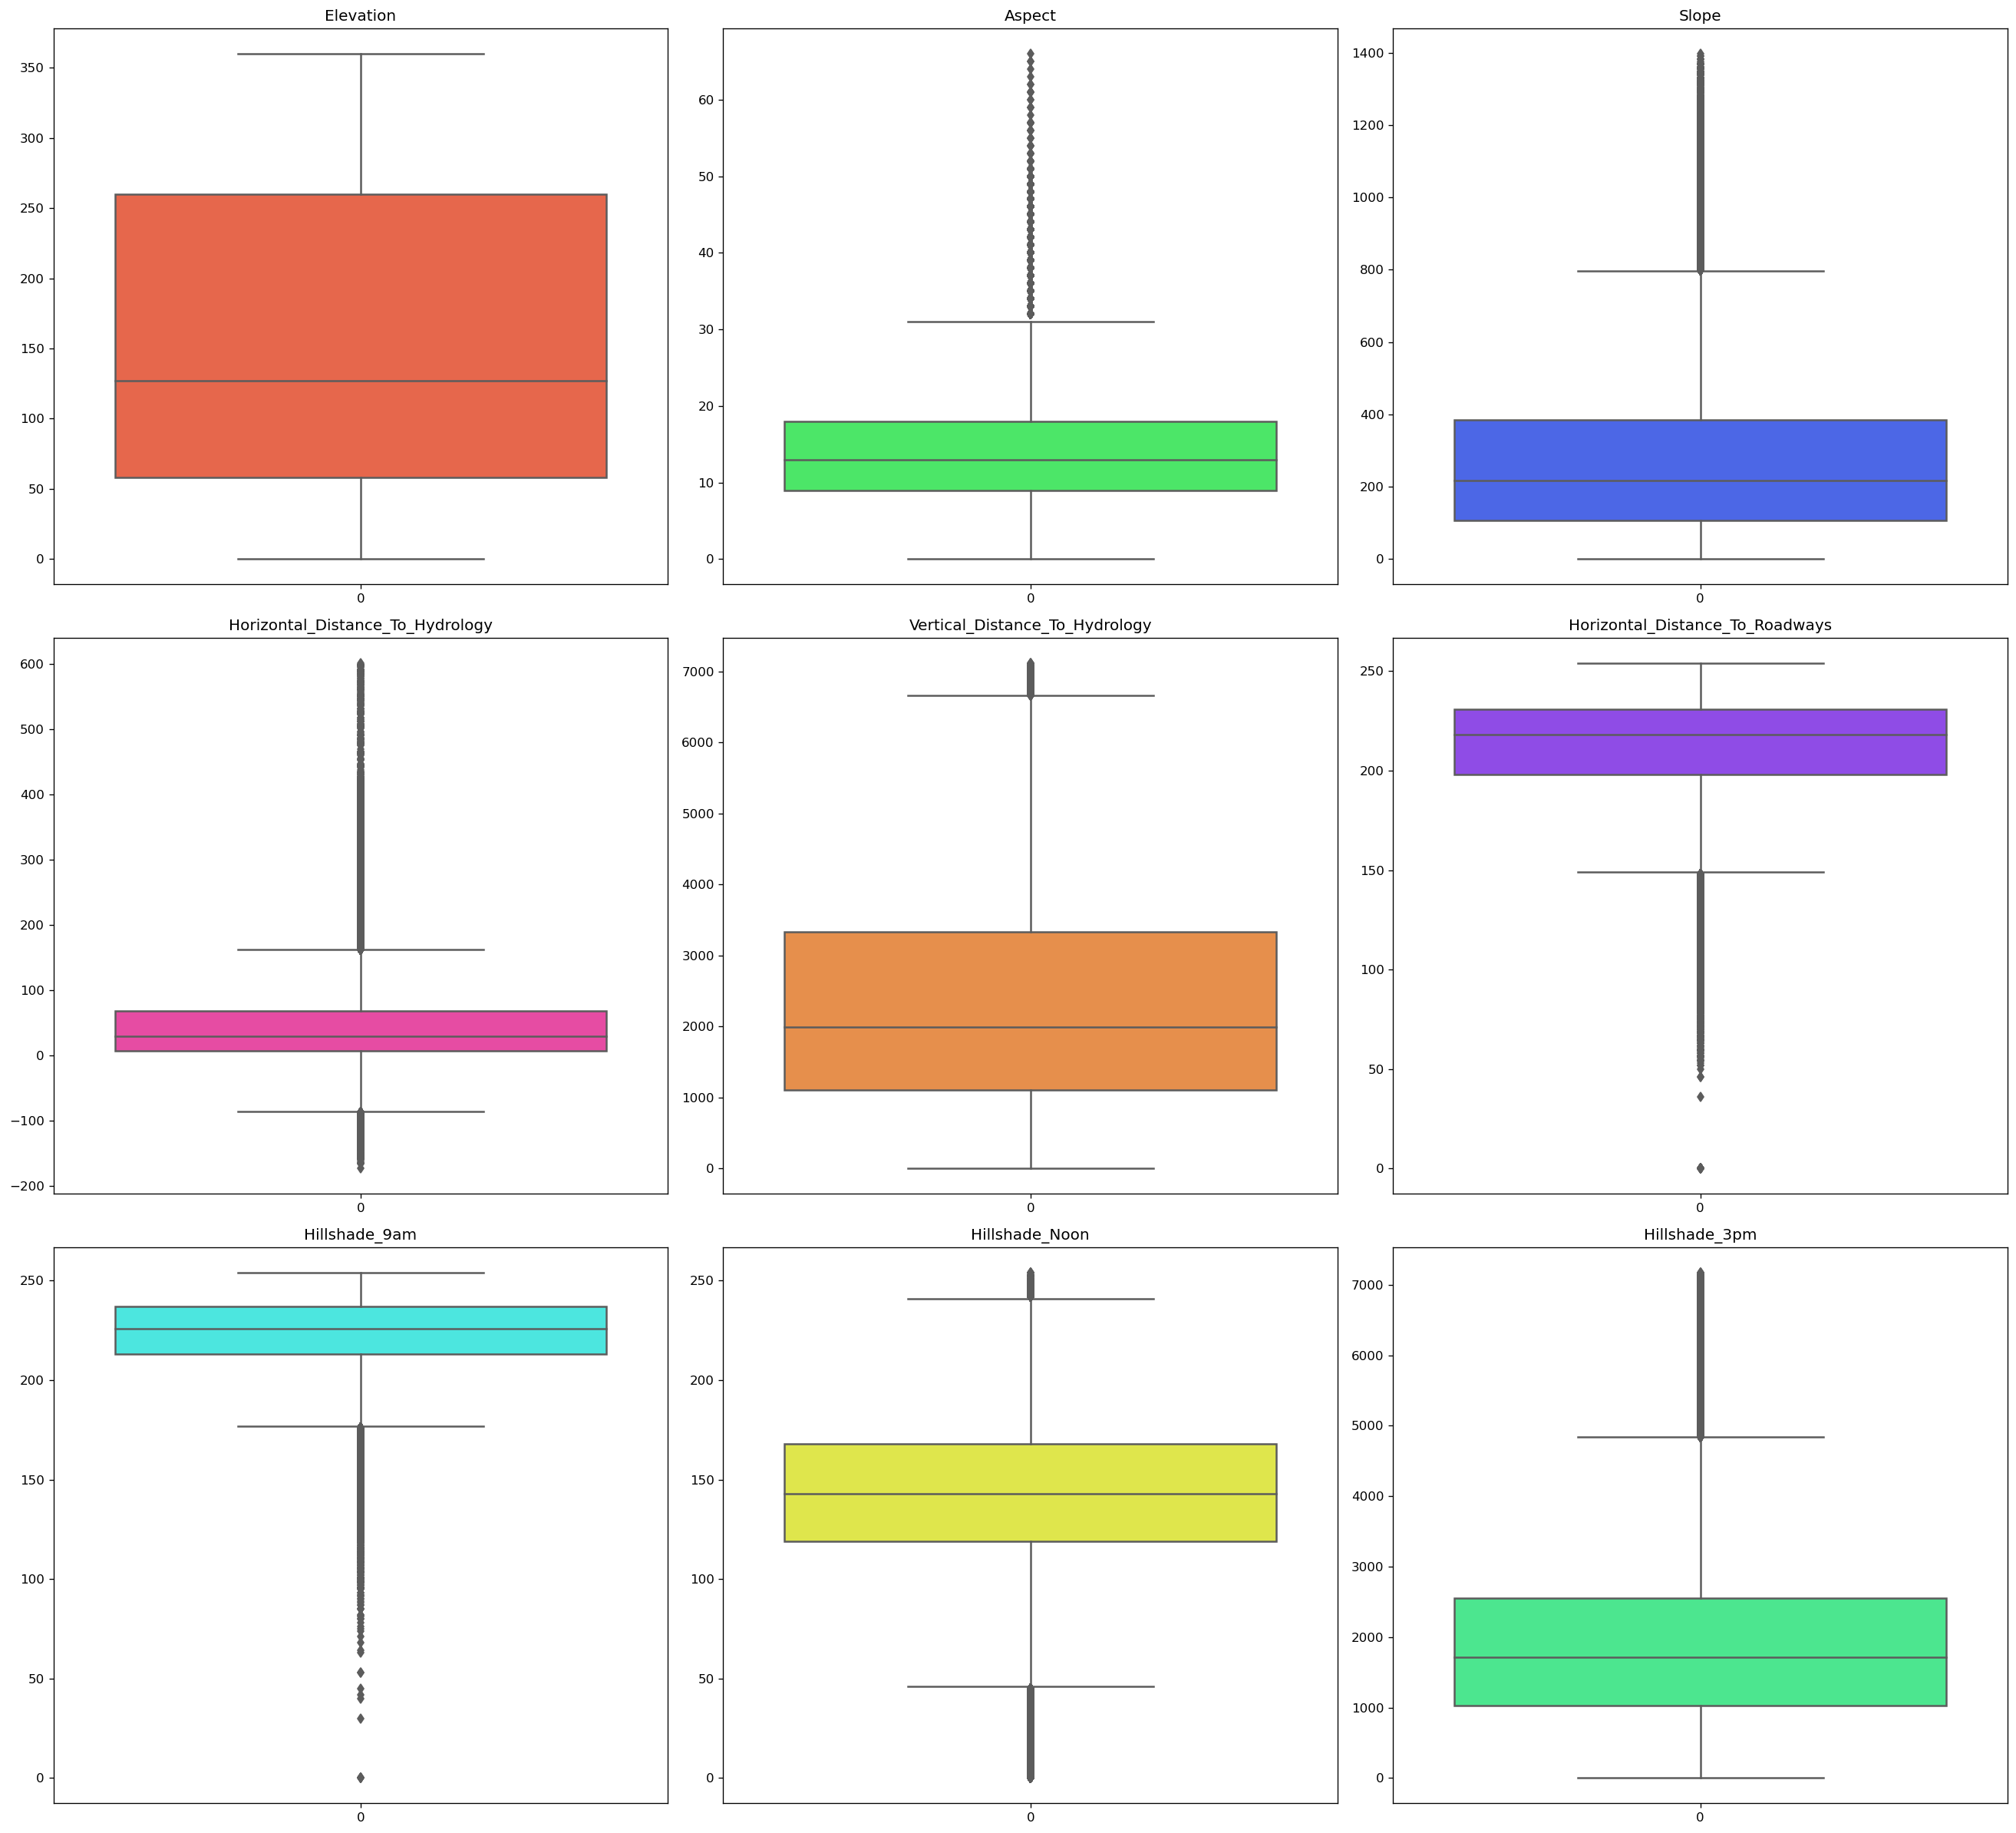

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,20), dpi=120)
for i in range(1, 10):
    sns.boxplot(data=df.iloc[:, i], showfliers=True, ax=axes.flat[i-1], color=custom_palette[i-1])
    axes.flat[i-1].set_title(column_names[i-1])
plt.tight_layout()
plt.show()

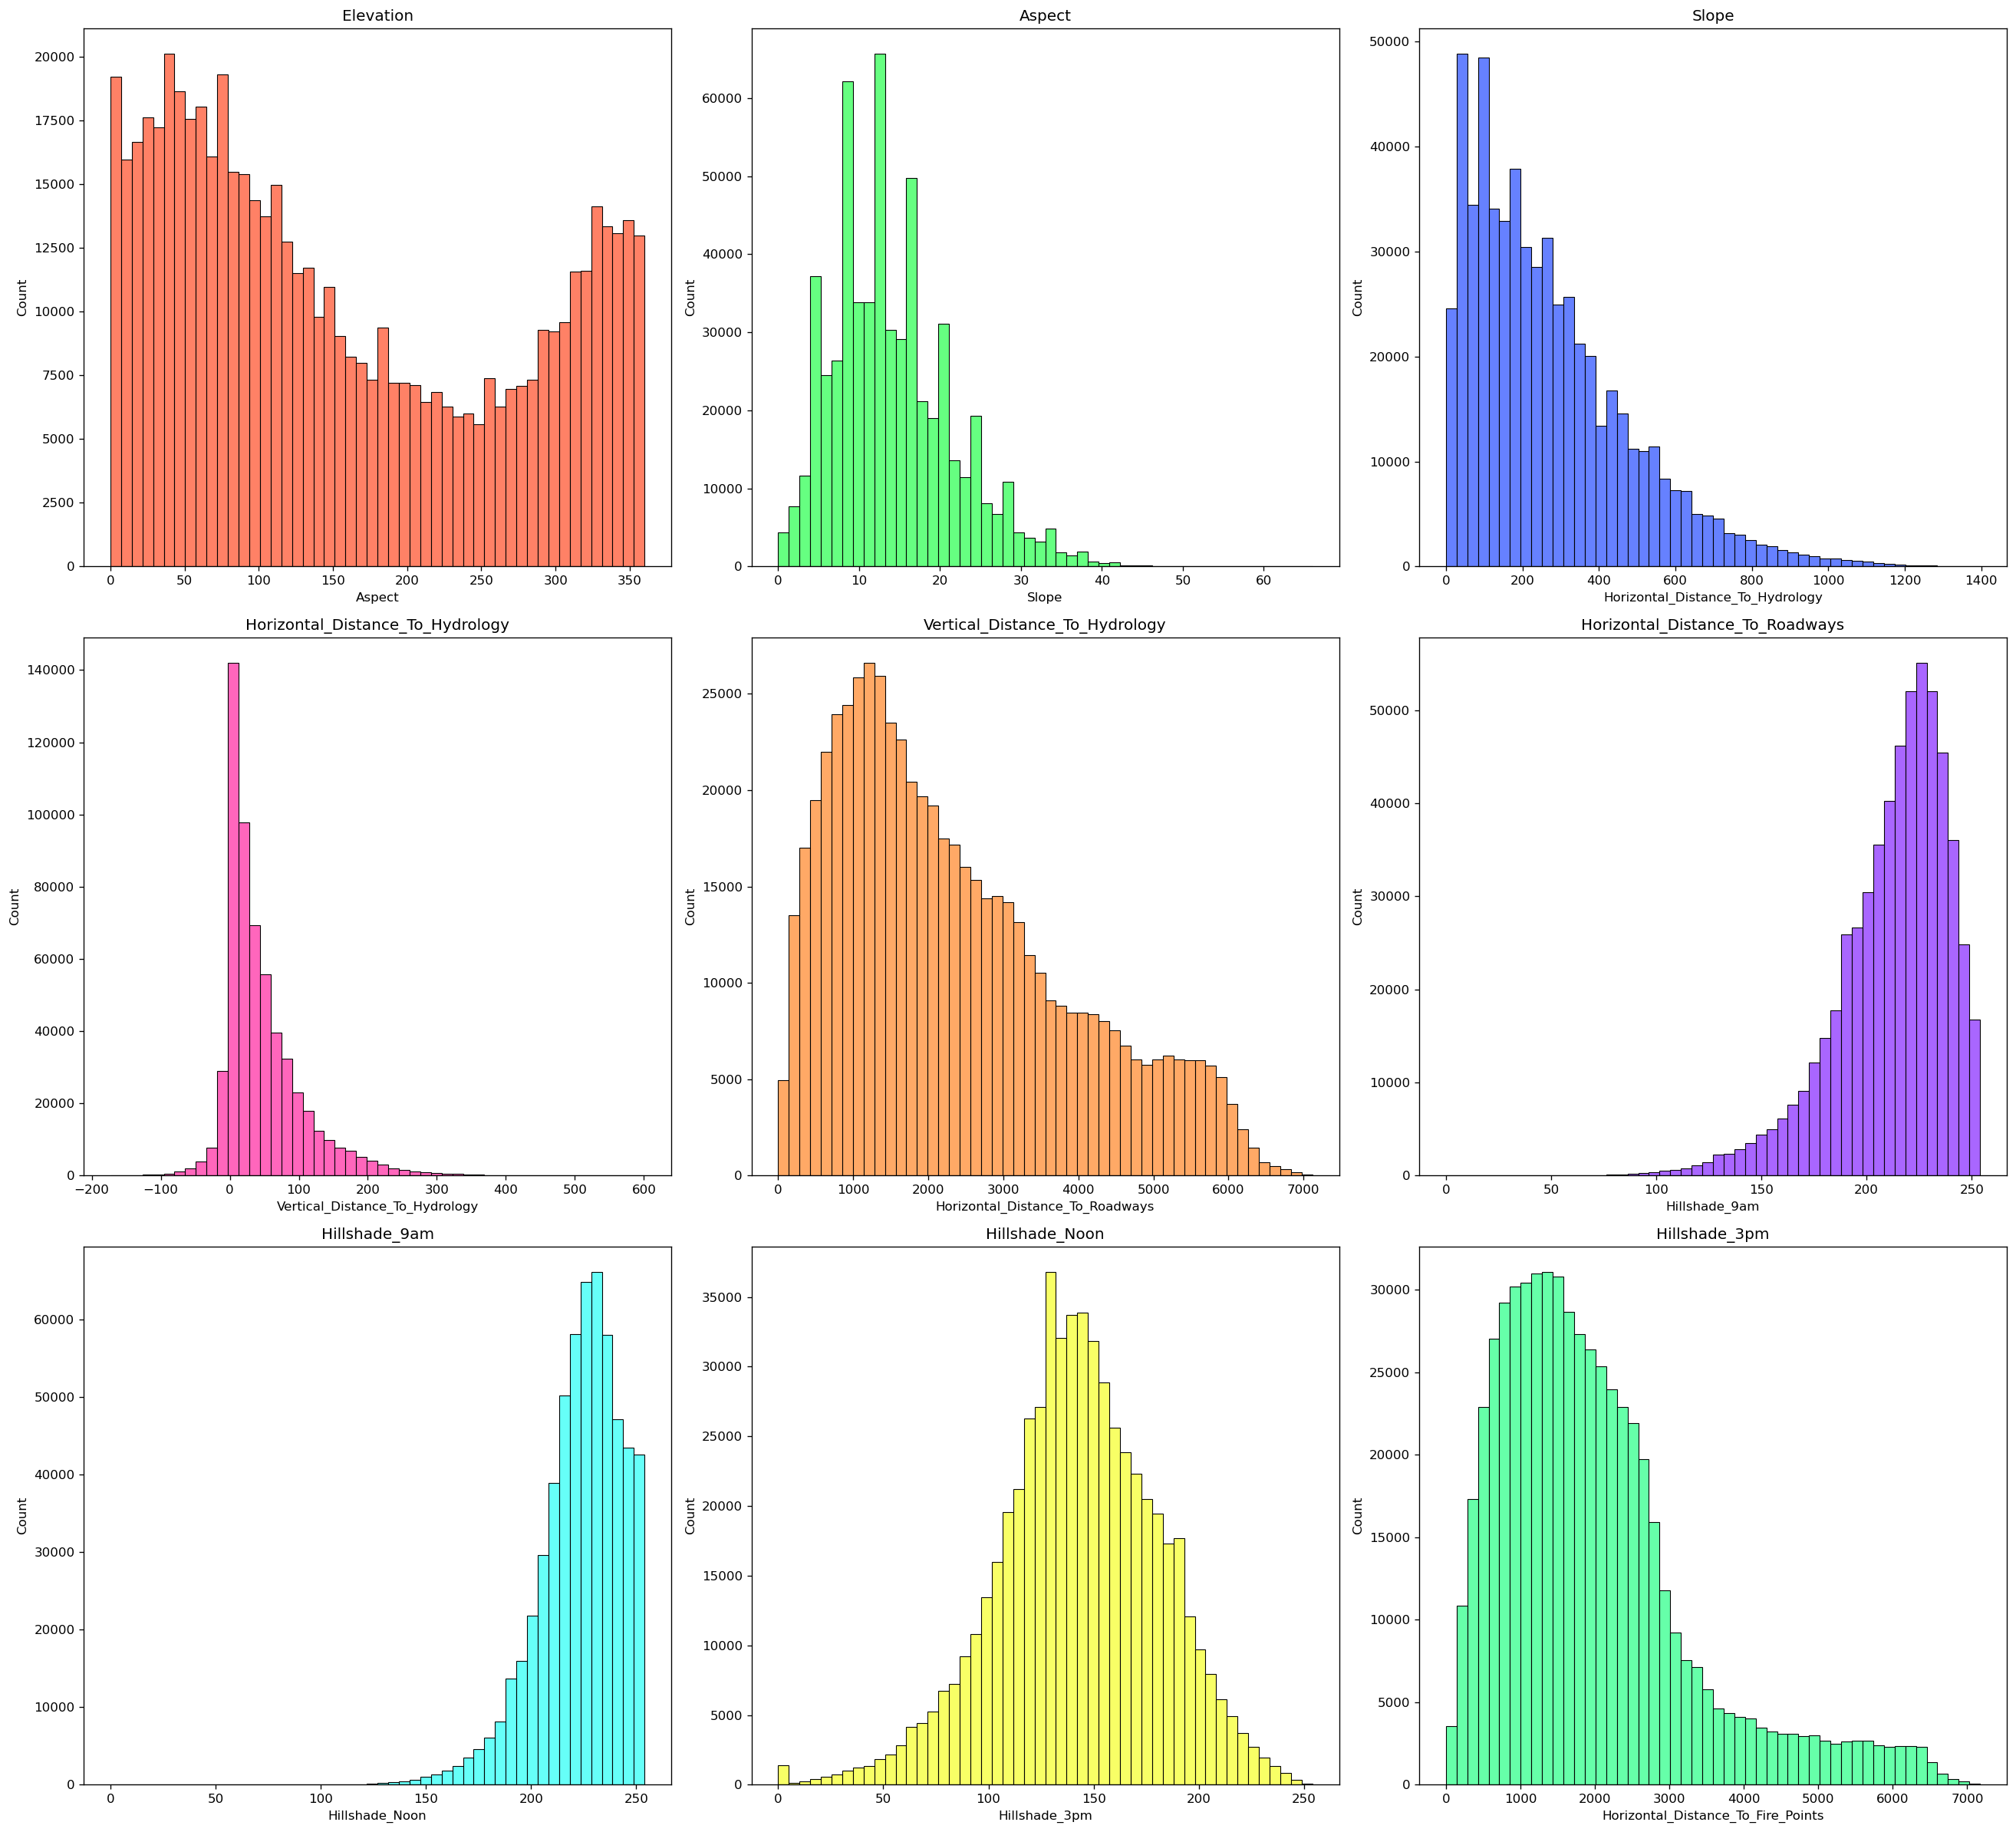

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(22,20), dpi=120)
for i in range(1, 10):
    sns.histplot(data=df.iloc[:, i], ax=axes.flat[i-1], color=custom_palette[i-1], bins=50)
    axes.flat[i-1].set_title(column_names[i-1])
plt.tight_layout()
plt.show()

In [15]:
df.isna().sum().sum()

0

### 3. Splitting Dataset

In [16]:
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"]

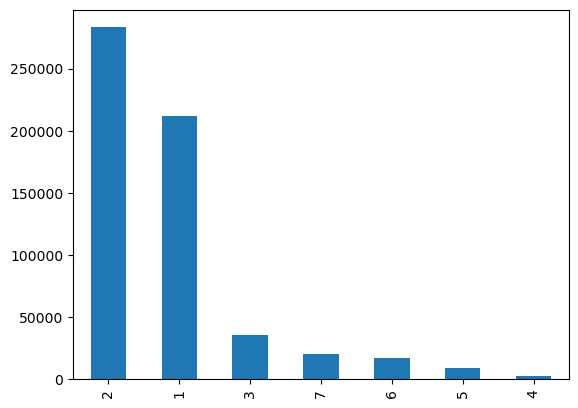

In [17]:
y.value_counts().plot(kind="bar")
plt.show()

The classes are notably imbalanced. For instance, if you had two classes, one of which had 99 examples and the other just 1, a model could always predict the first class, and it would be right 99% of the time! The model would score highly on accuracy, but it wouldn’t actually help you identify examples of the smaller class.

In [18]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)

In [19]:
X_under, y_under = undersample.fit_resample(X, y)

In [20]:
print(f"The loss of data for X is equivalent to: {(X.shape[0]- X_under.shape[0] ) * 100/ X.shape[0]:.1f}%")

The loss of data for X is equivalent to: 96.7%


In [21]:
print(f"The loss of data for y is equivalent to: {(y.shape[0]- y_under.shape[0] ) * 100/ y.shape[0]:.1f}%")

The loss of data for y is equivalent to: 96.7%


### Testing two imbalance approaches.

In [22]:
Xu_train, Xu_test, yu_train, yu_test = train_test_split(X_under, y_under, random_state=42, stratify=y_under)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [24]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=30, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

In [25]:
# Make predictions for the train and test set
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

In [26]:
print(f"Accuracy score of y_train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy score of y_test: {accuracy_score(y_test, y_pred_test):.4f}")

Accuracy score of y_train: 0.9999
Accuracy score of y_test: 0.9505


In [27]:
# View confusion matrix for test data and predictions
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[49913  2921     2     0    10     2   112]
 [ 1904 68564   163     2    80    91    21]
 [    4   163  8551    24     8   188     0]
 [    0     0    77   581     0    29     0]
 [   35   524    25     0  1777    12     0]
 [    5   126   327    24     4  3856     0]
 [  282    31     0     0     0     0  4815]]


In [28]:
cm = cm.astype("float") / cm.sum(axis=1)[:, None]

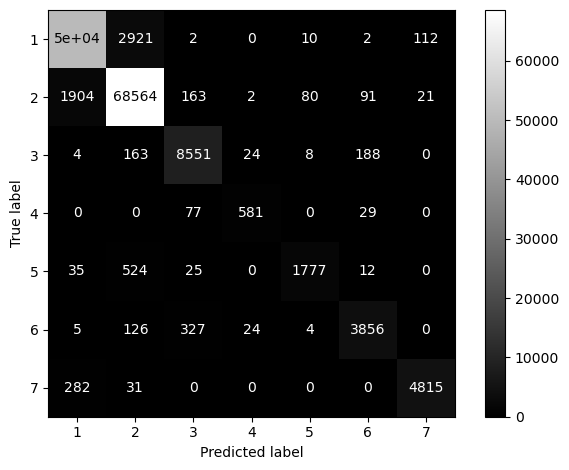

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_test, y_true=y_test, display_labels=forest.classes_, cmap="gray")
plt.tight_layout()
plt.show()

In [30]:
class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

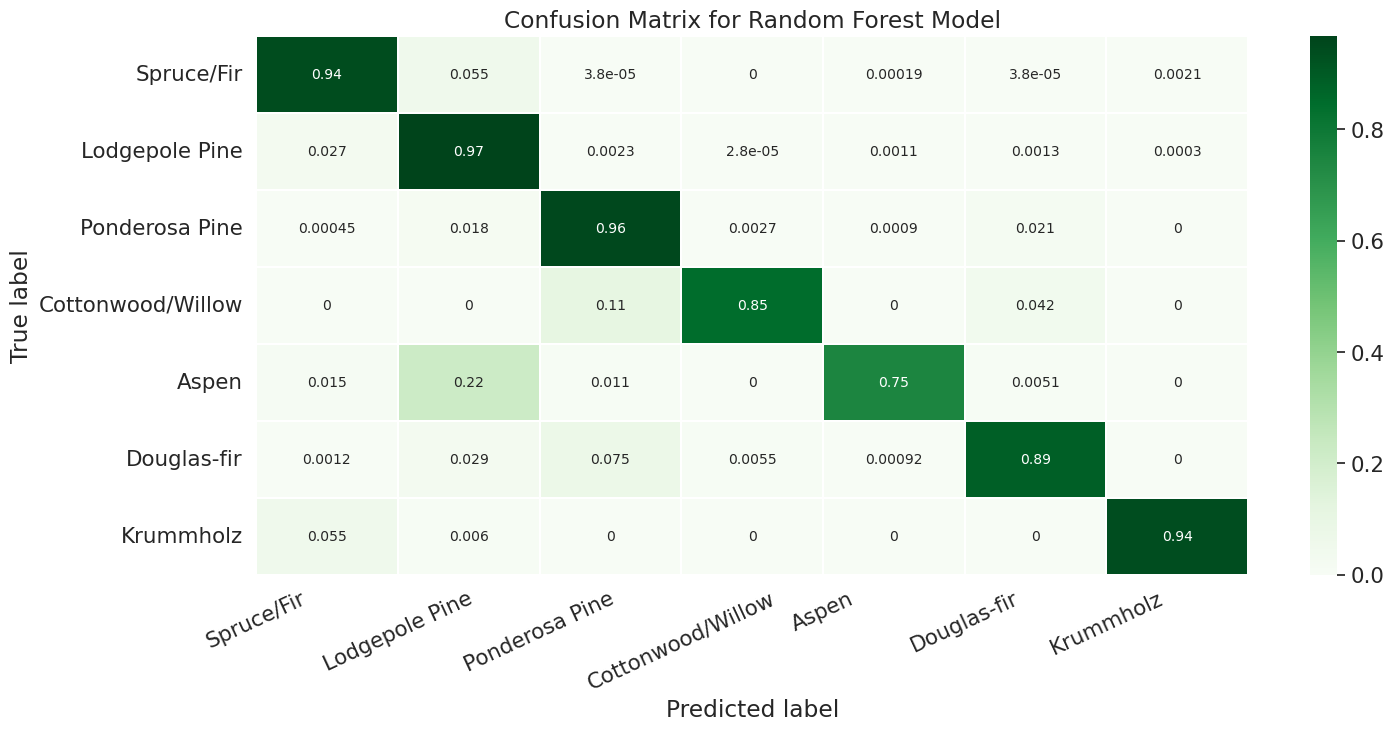

In [31]:
plt.figure(figsize=(16,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size":10}, cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

In [32]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.96      0.94      0.95     52960
           2       0.95      0.97      0.96     70825
           3       0.94      0.96      0.95      8938
           4       0.92      0.85      0.88       687
           5       0.95      0.75      0.84      2373
           6       0.92      0.89      0.91      4342
           7       0.97      0.94      0.96      5128

    accuracy                           0.95    145253
   macro avg       0.94      0.90      0.92    145253
weighted avg       0.95      0.95      0.95    145253



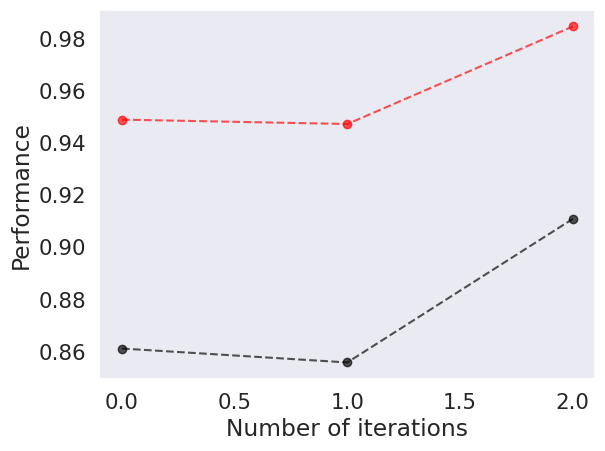

In [33]:
pe.performance_plot(3, X, y)

---

### Training balanced variable dataset

This approach is not recommendable for `df` because of high loss of data, circa 97%. Anyway, performance will be contrasted towards imbalanced address.

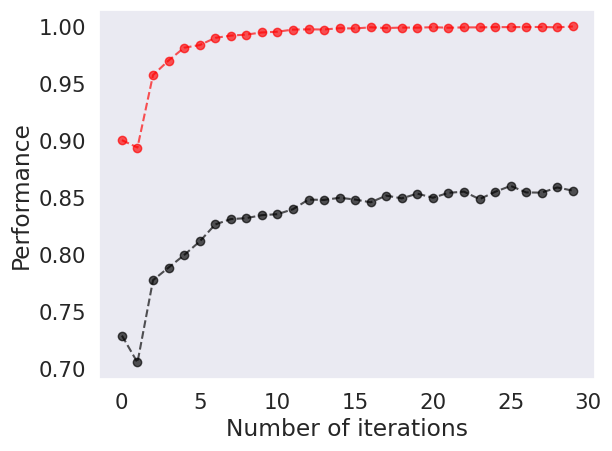

In [34]:
pe.performance_plot(30, X_under, y_under)

In [35]:
forest_felling = RandomForestClassifier(n_estimators=25, random_state=42)
forest_felling.fit(X_under, y_under)

RandomForestClassifier(n_estimators=25, random_state=42)

In [36]:
y_under_train_pred = forest_felling.predict(Xu_train)
y_under_test_pred = forest_felling.predict(Xu_test)

In [37]:
print(f"Accuracy score for train is: {accuracy_score(yu_train, y_under_train_pred):.5f}")
print(f"Accuracy score for test is: {accuracy_score(yu_test, y_under_test_pred):.5f}")

Accuracy score for train is: 0.99917
Accuracy score for test is: 0.99938


We can recognize a better accuracy score, close to 1, nevertheless overfitting can be possible owing to a considerable loss of data. This is also reflected on `confusion matrix`, we can find almost all values in matrix diagonal illustrated below.

In [38]:
cm_under = confusion_matrix(yu_test, y_under_test_pred)
print(cm_under)

[[686   0   0   0   0   0   0]
 [  1 685   0   0   1   0   0]
 [  0   0 686   1   0   0   0]
 [  0   0   0 687   0   0   0]
 [  0   0   0   0 687   0   0]
 [  0   0   0   0   0 687   0]
 [  0   0   0   0   0   0 687]]


### Decision Trees plot

In [39]:
# For imbalanced data.
clf_ = DecisionTreeClassifier(random_state=42, criterion="gini")
tree_ = clf_.fit(X,y)

In [63]:
# For balanced data with 96.7% of loss.
clf_under = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=2)
tree_u = clf_under.fit(X_under, y_under)

In [41]:
import graphviz
from sklearn import datasets

In [42]:
iris = datasets.load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [43]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [44]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [45]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target

In [46]:
I = iris_df.drop("target", axis=1)
j = iris_df["target"]

In [47]:
clf = DecisionTreeClassifier(random_state=00000, criterion="gini")
clf.fit(I, j)

DecisionTreeClassifier(random_state=0)

In [48]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
dot_data

'digraph Tree {\nnode [shape=box, style="filled", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="petal width (cm) <= 0.8\\ngini = 0.667\\nsamples = 150\\nvalue = [50, 50, 50]\\nclass = setosa", fillcolor="#ffffff"] ;\n1 [label="gini = 0.0\\nsamples = 50\\nvalue = [50, 0, 0]\\nclass = setosa", fillcolor="#e58139"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="petal width (cm) <= 1.75\\ngini = 0.5\\nsamples = 100\\nvalue = [0, 50, 50]\\nclass = versicolor", fillcolor="#ffffff"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="petal length (cm) <= 4.95\\ngini = 0.168\\nsamples = 54\\nvalue = [0, 49, 5]\\nclass = versicolor", fillcolor="#4de88e"] ;\n2 -> 3 ;\n4 [label="petal width (cm) <= 1.65\\ngini = 0.041\\nsamples = 48\\nvalue = [0, 47, 1]\\nclass = versicolor", fillcolor="#3de684"] ;\n3 -> 4 ;\n5 [label="gini = 0.0\\nsamples = 47\\nvalue = [0, 47, 0]\\nclass = versicolor", fillcolor="#39e581"]

In [49]:
!dot -V

dot - graphviz version 2.43.0 (0)


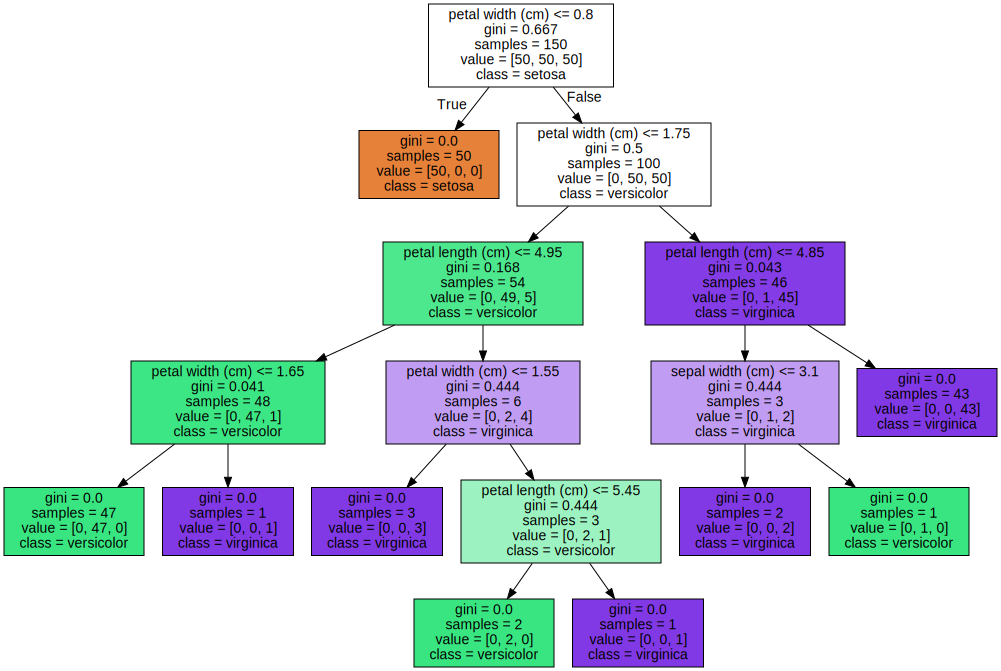

In [50]:
graphviz.Source(dot_data)

Now with our dataframe:

In [51]:
feature_names_X = np.array(X.columns.tolist())
class_names

['Spruce/Fir',
 'Lodgepole Pine',
 'Ponderosa Pine',
 'Cottonwood/Willow',
 'Aspen',
 'Douglas-fir',
 'Krummholz']

For imbalanced data:

In [54]:
imb_data = tree.export_graphviz(tree_, out_file=None, feature_names=feature_names_X, class_names=class_names, filled=True)

In [57]:
len(imb_data)

8355082

In [64]:
b_data = tree.export_graphviz(tree_u, out_file=None, feature_names=feature_names_X, class_names=class_names, filled=True)

In [65]:
len(b_data)

1278

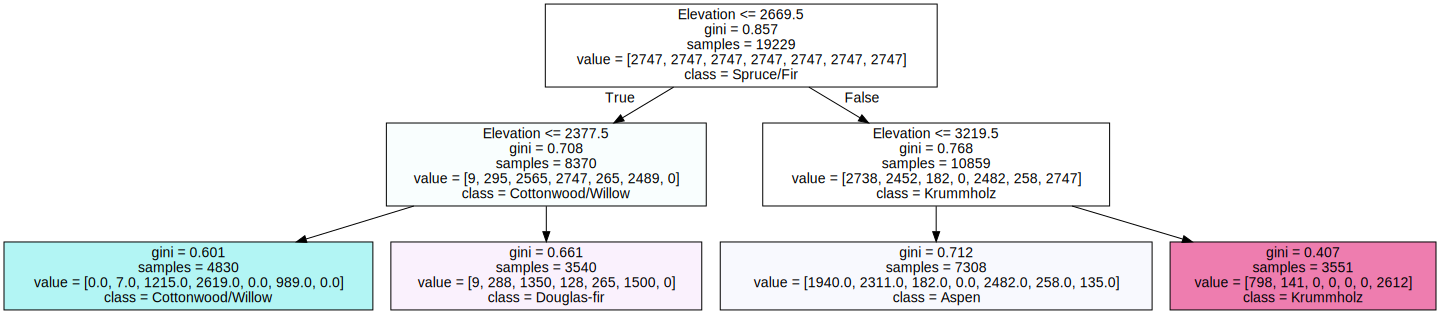

In [66]:
graphviz.Source(b_data)